In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 100)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [2]:
user = pd.read_csv('takehome_users.csv')
user['user_id'] = user.object_id
user.drop('object_id', inplace=True, axis=1)
user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5


In [3]:
engage = pd.read_csv('takehome_user_engagement.csv')
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [5]:
engage['week_stamp'] = engage.loc[:, 'time_stamp'].dt.to_period('W')
engage['diff'] = engage.week_stamp.diff()
engage.head(20)

,time_stamp,user_id,visited,week_stamp,diff
0,2014-04-22 03:53:30,1,1,2014-04-21/2014-04-27,NaN
1,2013-11-15 03:45:04,2,1,2013-11-11/2013-11-17,-23
2,2013-11-29 03:45:04,2,1,2013-11-25/2013-12-01,2
3,2013-12-09 03:45:04,2,1,2013-12-09/2013-12-15,2
4,2013-12-25 03:45:04,2,1,2013-12-23/2013-12-29,2
5,2013-12-31 03:45:04,2,1,2013-12-30/2014-01-05,1
6,2014-01-08 03:45:04,2,1,2014-01-06/2014-01-12,1
7,2014-02-03 03:45:04,2,1,2014-02-03/2014-02-09,4
8,2014-02-08 03:45:04,2,1,2014-02-03/2014-02-09,0
9,2014-02-09 03:45:04,2,1,2014-02-03/2014-02-09,0


In [6]:
grp = engage.groupby(['user_id', 'week_stamp']).size().max(level=0)

In [7]:
grp.head(20)

user_id
1     1
2     3
3     1
4     1
5     1
6     1
7     1
10    7
11    1
13    1
14    1
17    1
19    1
20    3
21    1
22    1
23    1
24    1
25    2
27    1
dtype: int64

In [8]:
week_uses = pd.DataFrame({'user_id': grp.index, 'week_use_max': grp.values})
week_uses.loc[week_uses.week_use_max>=3, 'adopted'] = 1
week_uses.adopted.fillna(0, inplace=True)
week_uses.adopted = week_uses.adopted.astype(int)
week_uses.head()

,user_id,week_use_max,adopted
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


In [9]:
week_uses.adopted.sum()

1445

In [10]:
df = user.merge(week_uses)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,week_use_max,adopted
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,1,0
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,3,1
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,1,0
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,1,0
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,1,0


In [11]:
# reduce number of different organizations with disecretization
org_user_n = df.org_id.value_counts()
org_n = pd.DataFrame({'org_id': org_user_n.index, 'org_user_n': org_user_n.values})
df = df.merge(org_n)
# disecretize organizations using quantiles based on # of users
df['org_user_size'] = pd.qcut(df.org_user_n, 5, ['sm', 'm', 'l', 'xl', 'xxl'])
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,week_use_max,adopted,org_user_n,org_user_size
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,1,0,56,xxl
1,2013-04-12 11:45:27,Goncalves Melissa,MelissaRibeiroGoncalves@yahoo.com,SIGNUP,1.365767e+09,0,0,11,NaN,151,1,0,56,xxl
2,2013-04-14 20:47:44,Millen Kai,KaiMillen@yahoo.com,ORG_INVITE,1.366059e+09,0,0,11,7701.0,179,1,0,56,xxl
3,2014-03-04 19:52:58,Simonsen Niels,NielsHSimonsen@jourrapide.com,PERSONAL_PROJECTS,1.394308e+09,1,0,11,NaN,254,2,0,56,xxl
4,2014-01-26 03:42:20,Bennett Anthony,AnthonyDBennett@yahoo.com,ORG_INVITE,1.401767e+09,1,0,11,6882.0,518,5,1,56,xxl


In [12]:
df = pd.concat([df, 
                pd.get_dummies(df.creation_source, prefix='creation'), 
                pd.get_dummies(df.org_user_size, prefix='org')], axis=1)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,week_use_max,adopted,org_user_n,org_user_size,creation_GUEST_INVITE,creation_ORG_INVITE,creation_PERSONAL_PROJECTS,creation_SIGNUP,creation_SIGNUP_GOOGLE_AUTH,org_sm,org_m,org_l,org_xl,org_xxl
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,1,0,56,xxl,1,0,0,0,0,0,0,0,0,1
1,2013-04-12 11:45:27,Goncalves Melissa,MelissaRibeiroGoncalves@yahoo.com,SIGNUP,1.365767e+09,0,0,11,NaN,151,1,0,56,xxl,0,0,0,1,0,0,0,0,0,1
2,2013-04-14 20:47:44,Millen Kai,KaiMillen@yahoo.com,ORG_INVITE,1.366059e+09,0,0,11,7701.0,179,1,0,56,xxl,0,1,0,0,0,0,0,0,0,1
3,2014-03-04 19:52:58,Simonsen Niels,NielsHSimonsen@jourrapide.com,PERSONAL_PROJECTS,1.394308e+09,1,0,11,NaN,254,2,0,56,xxl,0,0,1,0,0,0,0,0,0,1
4,2014-01-26 03:42:20,Bennett Anthony,AnthonyDBennett@yahoo.com,ORG_INVITE,1.401767e+09,1,0,11,6882.0,518,5,1,56,xxl,0,1,0,0,0,0,0,0,0,1


In [13]:
cols = df.columns[5:]
exCols = ['adopted', 'week_use_max', 'invited_by_user_id', 'user_id', 'org_id', 'org_user_size']
features = np.asarray([c for c in cols if c not in exCols])
features

array(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_user_n', 'creation_GUEST_INVITE', 'creation_ORG_INVITE',
       'creation_PERSONAL_PROJECTS', 'creation_SIGNUP',
       'creation_SIGNUP_GOOGLE_AUTH', 'org_sm', 'org_m', 'org_l', 'org_xl',
       'org_xxl'], 
      dtype='|S27')

In [15]:
seed = 979
forest = RandomForestClassifier(n_estimators=500,
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    n_jobs=-1, 
                                    random_state=seed)
cv_score = cross_val_score(forest, df[features], df.adopted, scoring='average_precision')
cv_score.mean(), cv_score.std()

(0.15893750125693221, 0.012216311384807492)

In [81]:
def rfFeatureImp(X, y, seed, suf, plot=True):
    '''
    Feature Importances from Random Forest
    '''
    forests = []

    forest = RandomForestClassifier(n_estimators=500,
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    n_jobs=-1, 
                                    random_state=seed)
    forest.fit(X, y)
    # feature importance, std, and max sorted index
    importance = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importance)[::-1]

    if plot:
        # Plot the Forest's feature importances for each CV split
        fig, ax = plt.subplots()


        ax.set_title("Feature importances: Overall RF")
        ax.bar(range(len(importance)), importance[indices],
               color="b", yerr=std[indices], align="center")
        ax.set_xticks(range(len(importance)))
        ax.set_xticklabels(features[indices], rotation='vertical')
        # ax.set_xticklabels(map(str, indices), rotation='vertical')
        ax.set_xlim([-1, len(importance)])
        #fig = plt.gcf()
        #fig.savefig('figs/rf_featImp_play'+suf+'.png', bbox_inches='tight', pad_inches=0)
        #plt.show()
    return importance, std, indices

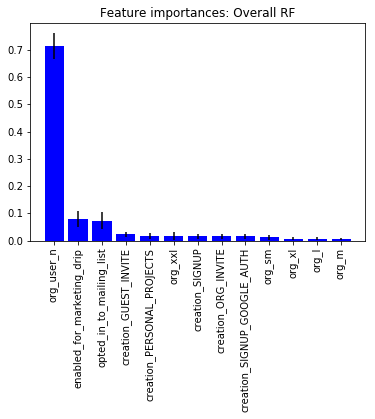

In [82]:
imp, std, idx = rfFeatureImp(df[features], df.adopted, seed, suf='na')

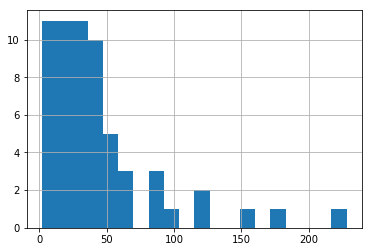

In [30]:
pd.Series(df.org_user_n).hist(bins=20)

In [17]:
df[df.adopted==0].org_user_n.mean(), df[df.adopted==1].org_user_n.mean()

(42.14055299539171, 30.747404844290656)

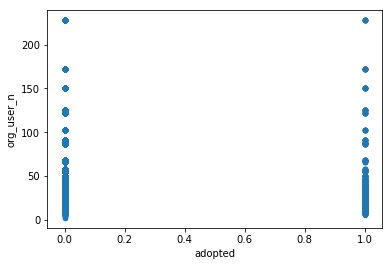

In [22]:
df.plot.scatter('adopted', 'org_user_n')

In the small set of features available, organizational use of and individual's openess to product marketing best predict future adoption. The most important features in the random forest were organizational size (# of users from each organization using the product), marketing drip enabled, and marketing list adoption. Average precision/recall AUC was low on the 3-fold cross validated random forest, more features and/or samples should be gathered. Helpful features might include product uses by user or scope/type of organizational use.